<a href="https://colab.research.google.com/github/Jaimemorillo/electoral-prediction-madrid/blob/main/read_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%load_ext rpy2.ipython

In [3]:
pip install pyvis

In [4]:
pip install python-igraph

In [5]:
pip install powerlaw

# Leemos los datos

In [6]:
import pandas as pd
import numpy as np
import networkx as nx
from IPython.core.display import display, HTML
from pyvis.network import Network
from sklearn.preprocessing import MinMaxScaler
import igraph as ig

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import seaborn as sns
sns.set_theme()
sns.set_context("notebook")

In [176]:
df = pd.read_csv('/content/gdrive/MyDrive/Tweets_elecciones/resultados_TFG_complete_1.csv', 
                 sep='~', encoding='utf-8', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,6,7,11,23,25,29,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [177]:
df['user_id'] = pd.to_numeric(df['user_id'], errors='coerce')
df = df.dropna(subset=['user_id'])
df['user_id'] = df['user_id'].astype(int)

df['followers_count'] = pd.to_numeric(df['followers_count'], errors='coerce')

In [178]:
df['created_at'] = df['created_at'].apply(lambda x: x[0:10])
df['account_created_at'] = df['account_created_at'].apply(lambda x: str(x)[0:10] if str(x)!='nan' else x)
df = df[df['created_at'].str.startswith('2021')]

In [179]:
df['created_at'].value_counts().sort_index()

2021-04-18     28916
2021-04-19     44833
2021-04-20     57404
2021-04-21    119003
2021-04-22    110267
2021-04-23     17443
2021-04-26    106456
2021-04-27    256889
2021-04-28    144848
2021-04-29      4215
Name: created_at, dtype: int64

In [180]:
def string_as_array(x):
  if x is not np.nan:
    return str(x).split(",")
  else:
    return np.nan

In [181]:
df.mentions_user_id = df.mentions_user_id.apply(lambda x: string_as_array(x))
df.mentions_screen_name = df.mentions_screen_name.apply(lambda x: string_as_array(x))
df.hashtags = df.hashtags.apply(lambda x: string_as_array(x))

In [182]:
df.head(10)

,user_id,name,status_id,screen_name,created_at,text,favorite_count,retweet_count,hashtags,mentions_user_id,mentions_screen_name,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,quoted_status_id,quoted_text,quoted_favorite_count,quoted_retweet_count,quoted_user_id,quoted_screen_name,retweet_status_id,retweet_user_id,retweet_screen_name,retweet_statuses_count,retweet_followers_count,retweet_friends_count,statuses_count,followers_count,friends_count,favourites_count,account_created_at
0,1314271330745937920,El Guerrero del Antifaz 🇪🇸🏴󠁧󠁢󠁥󠁮󠁧󠁿🇵🇪✝️,1.38521e+18,antifazporspain,2021-04-22,Elecciones de la Com. Madrid: la derecha PP y ...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11059.0,5318.0,5491.0,24543,2020-10-08
1,1174971439478239232,Juan Ángel,1.38521e+18,JuanAngelArMor,2021-04-22,El CIS pronostica un vuelco electoral con la v...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,FALSE,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12601.0,268.0,953.0,61975,2019-09-20
2,1174971439478239232,Juan Ángel,1.3852e+18,JuanAngelArMor,2021-04-22,La izquierda pierde porque no vota. Porque se ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,862102147,Гомо AragornEnsiZ🎗️,1.38521e+18,s0msirem,2021-04-22,@CosmonautGuy @MarcoMangut @VanderMonguer @Alb...,0,0,NaN,"[1878906385, 229154067, 1857019986, 91560739]","[CosmonautGuy, MarcoMangut, VanderMonguer, Alb...",1.38499e+18,1878906385,CosmonautGuy,FALSE,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,115914.0,927.0,935.0,9777,2012-10-04
5,893110171,Carles Casamayor,1.38521e+18,CarlesCasamayor,2021-04-22,@CarlesCasamayor @El_Plural De lo que no se ha...,0,1,NaN,"[484693767, 893110171, 158313996]","[JosMHernndezV, CarlesCasamayor, El_Plural]",NaN,NaN,NaN,FALSE,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,1.385097e+18,4.84694e+08,JosMHernndezV,25139,613.0,802,23757.0,2105.0,1368.0,41709,2012-10-20
6,940699411168092032,Andrés Agustin Duran,1.38521e+18,AndresAgustinD2,2021-04-22,"Gabilondo: \Querido Pablo, espero tu apoyo\""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,940699411168092032,Andrés Agustin Duran,1.38519e+18,AndresAgustinD2,2021-04-22,"PSOE, Podemos, ERC y Bildu salvan a Marlaska d...",0,71,NaN,[1120274781289558017],[veintimillapier],NaN,NaN,NaN,FALSE,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,1.385189e+18,1.12027e+18,veintimillapier,21980,14588.0,15566,197155.0,3657.0,5005.0,226130,2017-12-12
9,940699411168092032,Andrés Agustin Duran,1.38517e+18,AndresAgustinD2,2021-04-22,"🔴 #ÚLTIMAHORA El CIS de Tezanos baja al PP 2,5...",0,8,[ÚLTIMAHORA],[19923515],[abc_es],NaN,NaN,NaN,FALSE,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,1.385167e+18,1.99235e+07,abc_es,481091,2115573.0,14830,197155.0,3657.0,5005.0,226130,2017-12-12
10,940699411168092032,Andrés Agustin Duran,1.38519e+18,AndresAgustinD2,2021-04-22,Tezanos trata de reanimar a la izquierda con u...,0,5,NaN,[826854837304360960],[Ricardo13625223],NaN,NaN,NaN,FALSE,TRUE,NaN,NaN,NaN,NaN,NaN,NaN,1.385190e+18,8.26855e+17,Ricardo13625223,39621,12716.0,11006,197155.0,3657.0,5005.0,226130,2017-12-12
11,1359897132006846464,Manu †,1.38514e+18,soyunbotfacha,2021-04-22,"@julioberm @_esthersanz Personalmente, conozco...",0,0,NaN,"[281178448, 1000098956318269446]","[julioberm, _esthersanz]",1.38514e+18,281178448,julioberm,FALSE,FALSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2287.0,361.0,124.0,6365,2021-02-11


In [183]:
df.retweet_screen_name.value_counts()[0:10]

pons_sabate        26969
PSOE               24673
rosadiezglez       15305
Alvisepf           13486
Roberto10513054    11616
CensoredJules      10383
PODEMOS             9201
JulianMaciasT       8882
gmaemejota          8821
alfonso_ussia       8669
Name: retweet_screen_name, dtype: int64

In [184]:
print(df.screen_name.shape)
print(df.screen_name.value_counts().shape)

# De casi 900.000 tweets usuarios únicos hay 100.000

(890274,)
(106257,)


# Creamos los nodos y las aristas

Nodos = usuarios de twitter.

A->B si B da retweet a A

Asignamos pesos a las aristas en función del número de RTs

In [185]:
# Calculamos las aristas y los nodos
df_temp = df[['screen_name','retweet_screen_name']]
df_temp = df_temp[df_temp['screen_name']!=df_temp['retweet_screen_name']]
df_edge_list = df_temp.copy()
df_edge_list = df_edge_list.groupby(['screen_name', 'retweet_screen_name'], as_index=False).size().rename(columns={'size': 'weight'})
nodes_no_conection = df_temp[pd.isnull(df_temp['retweet_screen_name'])] # ¿Qué hacemos con los tweets aislados?
df_edge_list['width'] = df_edge_list['weight']

#df_edge_list = df_edge_list.sample(2000, random_state=9)
#df_edge_list = df_edge_list.head(20000)

nodes_size = df_edge_list.groupby('retweet_screen_name', as_index=False).size()
nodes_size['size'] = MinMaxScaler(feature_range=(5,50)).fit_transform(nodes_size['size'].values.reshape(-1,1))

#df_edge_list = df_edge_list.join(nodes.set_index('retweet_screen_name'), on='retweet_screen_name')
#df_edge_list = df_edge_list.sort_values('size', ascending=False)

In [186]:
df_edge_list

,screen_name,retweet_screen_name,weight,width
0,00000_O_O,CCivicaCatalana,2,2
1,00000_O_O,MariaTabarnia,1,1
2,000333dani,AgIzquierda,2,2
3,000333dani,AmoedoCom,2,2
4,000333dani,BenderOfuscado,1,1
...,...,...,...,...
278587,zzzz46324949,Zapatista72,5,5
278588,zzzz46324949,_PabloFdez_,1,1
278589,zzzz46324949,gerardotc,1,1
278590,zzzz46324949,gmaemejota,1,1


In [188]:
#Calculamos atributos de los nodos
df_temp1 = df[['screen_name','statuses_count','followers_count','friends_count',
               'created_at','favourites_count','account_created_at']]
df_temp2 = df[['retweet_screen_name','retweet_statuses_count',
               'retweet_followers_count','retweet_friends_count','created_at']]
df_temp2['favourites_count'] = np.nan
df_temp2['account_created_at'] = np.nan
df_temp2.columns = df_temp1.columns
df_temp = df_temp2.append(df_temp1).reset_index(drop=True).dropna(subset=['screen_name'])
df_temp = df_temp.dropna(subset=['followers_count'])
nodes = df_temp.drop_duplicates(subset=['screen_name'], keep='last').reset_index(drop=True)
nodes['days_old'] = (pd.to_datetime(nodes['created_at']) - pd.to_datetime(nodes['account_created_at'])).dt.days

nodes['statuses_count'] = nodes['statuses_count'].astype(int)
nodes['followers_count'] = nodes['followers_count'].astype(int)
nodes['friends_count'] = nodes['friends_count'].astype(int)
nodes['favourites_count'] = nodes['favourites_count'].astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [189]:
nodes.dtypes

screen_name            object
statuses_count          int64
followers_count         int64
friends_count           int64
created_at             object
favourites_count      float64
account_created_at     object
days_old              float64
dtype: object

In [190]:
G = nx.from_pandas_edgelist(df_edge_list, 
                            source='retweet_screen_name',
                            target='screen_name',
                            edge_attr=['weight','width'],
                            create_using=nx.DiGraph())

nx.set_node_attributes(G, pd.Series(nodes_size.set_index('retweet_screen_name')['size']).to_dict(), 'size')
nx.set_node_attributes(G, pd.Series(nodes.set_index('screen_name')['statuses_count']).to_dict(), 'statuses_count')
nx.set_node_attributes(G, pd.Series(nodes.set_index('screen_name')['followers_count']).to_dict(), 'followers_count')
nx.set_node_attributes(G, pd.Series(nodes.set_index('screen_name')['friends_count']).to_dict(), 'friends_count')
nx.set_node_attributes(G, pd.Series(nodes.set_index('screen_name')['favourites_count']).to_dict(), 'favourites_count')
nx.set_node_attributes(G, pd.Series(nodes.set_index('screen_name')['days_old']).to_dict(), 'days_old')

In [191]:
vertex_df_ini = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

tuples = [tuple(x) for x in df_edge_list[['retweet_screen_name','screen_name','weight']].values]
g = ig.Graph.TupleList(tuples, directed = True, edge_attrs = ['weight'])

g.vs["statuses_count"] = vertex_df_ini.statuses_count.values
g.vs["followers_count"] = vertex_df_ini.followers_count.values
g.vs["friends_count"] = vertex_df_ini.friends_count.values
g.vs["favourites_count"] = vertex_df_ini.favourites_count.values
g.vs["days_old"] = vertex_df_ini.days_old.values

# Pintamos la red

Al pintar la red con una muestra de unos 2000 nodos del primer día de campaña se ve que la izquierda y la derecha se encuentra bastante bien divididas.

Toni Canto claramente está emparejado con vox cuando él pertenece a Cs. O al PP, pero lo que hace claramente lo pone en otra "Comunidad". Esto se verá mucho más claro cuando hagamos comunidades

In [ ]:
net = Network(height='720px', width='1280px', notebook=True, directed=True)
net.from_nx(G)

net.show('red.html')
display(HTML('red.html'))

# Motifs

He calculado la frecuencia de los motifs de tamaño 3 y he visto que las relaciones que se dan son siempre de dominancia.

Las estructuras están centralizadas entorno a los nodos que originan la información (creadores de contenido viral), que casi siempre son los propios partidos o sus políticos.

Desde el punto de vista estructural, tenemos cosas interesantes y es que las tres subestructuras que se dan son

CASO 1. De trasmiision directa A manda a B y C caso más habitual. Viralización.

CASO 2. a y b mandan a C. Esta estructura es curiosa y es gente que escucha de varios lideres.

CASO 3. A --b --C menos frecuente pero denota cierta intermediación de algunos tuiteros. La informacion no siembre se escucha directamente desde el emisor sino que recorre caminos de mayor longitud por lo que ciertos actores son relevantes en la intermediación.

No hay casi ciclos A con B, B con C y C con A (QUE SERIA LO LÓGICO EN UN DEBATE DONDE FLUYE LA INFORMACIÓN). 

Con los motifs de tamaño 4 vemos que los más frecuentes son los derivados de las estructuras de tamaño 3 vistas antes, lo más importante aquí es ver que no encontramos cadenas de 4 nodos A->B->C->D.

In [ ]:
def get_motifs(g, size=3):
  motifs = g.motifs_randesu(size=size, cut_prob=None)
  for idx,i in enumerate(motifs):
    if i>=5000 and not np.isnan(i):
      print('freq: ' + str(i))
      print(ig.Graph.Isoclass(n=size, cls=idx, directed=True))
      print('--------------------------------------------')
  return None

In [ ]:
get_motifs(g,3)

freq: 113023
IGRAPH D--- 3 2 --
+ edges:
2->0 1->0
--------------------------------------------
freq: 64940
IGRAPH D--- 3 2 --
+ edges:
0->1 2->0
--------------------------------------------
freq: 24142584
IGRAPH D--- 3 2 --
+ edges:
2->1 2->0
--------------------------------------------
freq: 10453
IGRAPH D--- 3 3 --
+ edges:
2->1 2->0 1->0
--------------------------------------------
freq: 15378
IGRAPH D--- 3 3 --
+ edges:
0->2 0->1 1->0
--------------------------------------------


In [ ]:
get_motifs(g,4)

freq: 123952
IGRAPH D--- 4 3 --
+ edges:
3->0 2->0 1->0
--------------------------------------------
freq: 15789
IGRAPH D--- 4 3 --
+ edges:
0->1 3->0 2->0
--------------------------------------------
freq: 21928
IGRAPH D--- 4 3 --
+ edges:
2->1 3->0 1->0
--------------------------------------------
freq: 10009449
IGRAPH D--- 4 3 --
+ edges:
2->1 3->0 2->0
--------------------------------------------
freq: 9537
IGRAPH D--- 4 4 --
+ edges:
2->1 3->0 2->0 1->0
--------------------------------------------
freq: 5622
IGRAPH D--- 4 4 --
+ edges:
2->1 0->1 3->0 2->0
--------------------------------------------
freq: 190837
IGRAPH D--- 4 4 --
+ edges:
3->1 2->1 3->0 2->0
--------------------------------------------
freq: 1535
IGRAPH D--- 4 5 --
+ edges:
3->1 2->1 3->0 2->0 1->0
--------------------------------------------
freq: 401816
IGRAPH D--- 4 3 --
+ edges:
0->2 0->1 3->0
--------------------------------------------
freq: 1737
IGRAPH D--- 4 4 --
+ edges:
0->2 0->1 3->0 1->0
-------------

# Estadísticos

- **Vértices**: 33040
- **Aristas dirigidas**: 63174
- **Grado de salida medio**: 1.91 - **desviación típica**: 38.23 	(Distribución de cola pesada)
- **Grado de entrada medio**: 1.91 - **desviación típica**: 2.43
- **Componente más largo**: 59 - 0.18% de los vértices
- **Diametro (lmax)**: 17 (https://mathworld.wolfram.com/GraphDiameter.html)
- **Distancia media \<l>**: 4.85 https://www.sciencedirect.com/topics/computer-science/geodesic-distance
- **Densidad**: 6e-5 https://es.wikipedia.org/wiki/Densidad_(teor%C3%ADa_de_grafos)
- **Coeficiente de agrupamiento (global)**: 3e-04 https://en.wikipedia.org/wiki/Clustering_coefficient

In [192]:
print(g.vcount())
print(g.ecount())

88482
278592


In [193]:
vertex_df = g.get_vertex_dataframe()
vertex_df['degree'] = g.degree()
vertex_df['out_degree'] = g.outdegree()
vertex_df['in_degree'] = g.indegree()

In [194]:
vertex_df[['degree','out_degree','in_degree']].describe().round(2)

,degree,out_degree,in_degree
count,88482.0,88482.00,88482.00
mean,6.3,3.15,3.15
std,68.4,68.08,5.86
min,1.0,0.00,0.00
25%,1.0,0.00,1.00
50%,1.0,0.00,1.00
75%,3.0,0.00,3.00
max,8690.0,8689.00,154.00


In [195]:
vertex_df.out_degree.quantile(0.90)

1.0

In [196]:
cl = g.clusters(mode='strong') # Calculates the (strong or weak) clusters (connected components) for a given graph.
lcc = cl.giant() #Returns the largest cluster
print(lcc.vcount()) #Vertices of largest component
print("{0:.2%}".format((lcc.vcount()/g.vcount()))) #Vertices of largest component in percentage
print(g.diameter()) #if the graph is unconnected, the longest geodesic within a component will be returned.
print(g.average_path_length()) #longitud media
print(round(g.density(),5)) #densidad media
print(g.transitivity_undirected())
print(nx.transitivity(G)) #No esta en igraph, solo para no dirigidos, coeficiente de clustering

1748
1.98%
33
10.949901065294277
4e-05
0.0023015922571508183
0.00045178353704122376


## Gini Coefficient
https://towardsdatascience.com/measuring-statistical-dispersion-with-the-gini-coefficient-22e4e63463af

https://geographicdata.science/book/notebooks/09_spatial_inequality.html

In [197]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [226]:
def plot_lorenz_curve(series, name, ax):
  gini_v = gini(series.astype('float').to_numpy())
  n = len(series)
  share_of_population = np.arange(1, n+1) / n
  incomes = series.sort_values()
  shares = incomes / incomes.sum()
  cumulative_share = shares.cumsum()
  ax.plot(share_of_population, cumulative_share, label='Lorenz Curve')
  ax.plot((0,1), (0,1), color='r', label='Perfect Equality')
  ax.set_xlabel('Share of population')
  ax.set_ylabel('Share of ' + name)
  ax.set_title(name + ' ' + '(Gini = %0.2f)' % gini_v)
  ax.legend()

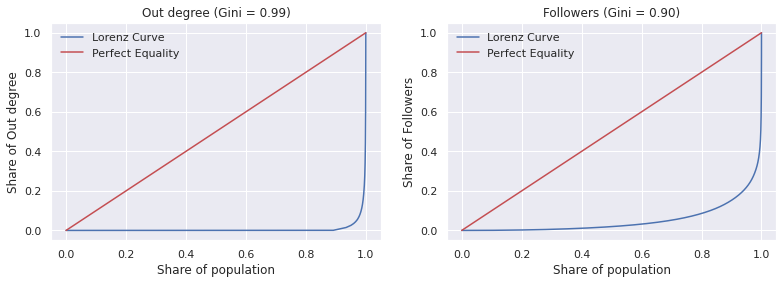

In [227]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(13,4))
plt.subplots_adjust(wspace=0.2)
plot_lorenz_curve(vertex_df.out_degree, 'Out degree', ax1)
plot_lorenz_curve(vertex_df.followers_count, 'Followers', ax2)

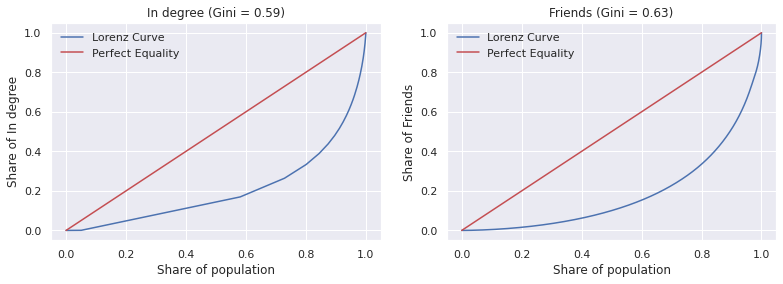

In [228]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(13,4))
plt.subplots_adjust(wspace=0.2)
plot_lorenz_curve(vertex_df.in_degree, 'In degree', ax1)
plot_lorenz_curve(vertex_df.friends_count, 'Friends', ax2)

# Null model

## Erdos-Renyi model

p= \<k>/(n-1)

In [229]:
p = ig.mean(g.outdegree())/(g.vcount()-1)
round(p,5)

4e-05

In [230]:
er_g = ig.Graph().Erdos_Renyi(n=g.vcount(), p=p, directed=True)
E = er_g.get_edgelist()
er_G = nx.DiGraph(E)

In [231]:
vertex_er_df = er_g.get_vertex_dataframe()
vertex_er_df['degree'] = er_g.degree()
vertex_er_df['out_degree'] = er_g.outdegree()
vertex_er_df['in_degree'] = er_g.indegree()

In [232]:
vertex_er_df.describe().round(2)

,degree,out_degree,in_degree
count,88482.00,88482.00,88482.00
mean,6.28,3.14,3.14
std,2.50,1.77,1.77
min,0.00,0.00,0.00
25%,5.00,2.00,2.00
50%,6.00,3.00,3.00
75%,8.00,4.00,4.00
max,22.00,13.00,13.00


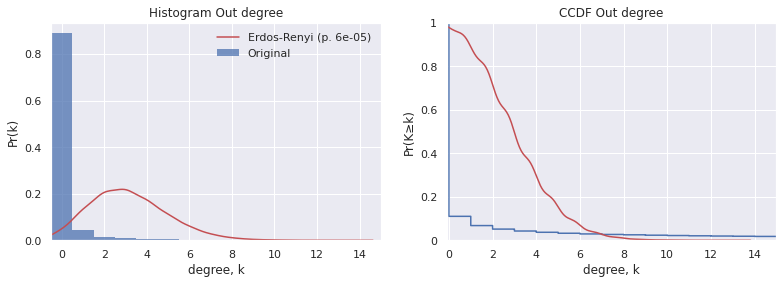

In [233]:
# Out degree
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(13,4))
plt.subplots_adjust(wspace=0.2)

sns.histplot(data=vertex_df, x='out_degree',stat='probability',discrete=True,label='Original',ax=ax1)
sns.kdeplot(data=vertex_er_df, x='out_degree', bw_adjust=3, color='r', label='Erdos-Renyi (p. 6e-05)',ax=ax1)
ax1.set_xlim(-.5, 15)
ax1.set_ylabel('Pr(k)')
ax1.set_xlabel('degree, k')
ax1.legend()
ax1.set_title('Histogram Out degree')

sns.ecdfplot(data=vertex_df,x='out_degree',complementary=False,label='Original',ax=ax2)
sns.kdeplot(data=vertex_er_df,x='out_degree',color='r',cumulative=True,bw_adjust=1.5,label='Erdos-Renyi (p. 6e-05)',ax=ax2)
yticks=ax2.get_yticks()
ax2.invert_yaxis()
ax2.set_yticklabels([1,0.8,0.6,0.4,0.2,0])
ax2.set_xlim(-.1, 15)
ax2.set_ylabel('Pr(K≥k)')
ax2.set_xlabel('degree, k')
ax2.set_title('CCDF Out degree')
plt.show()

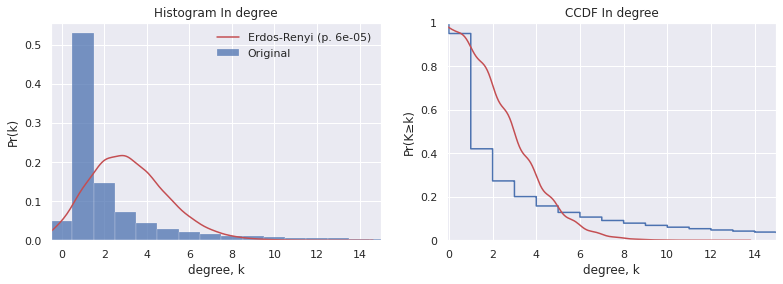

In [234]:
# In degree
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(13,4))
plt.subplots_adjust(wspace=0.2)

sns.histplot(data=vertex_df, x='in_degree',stat='probability',discrete=True,fill=True,label='Original',ax=ax1)
sns.kdeplot(data=vertex_er_df, x='in_degree', bw_adjust=3, color='r',label='Erdos-Renyi (p. 6e-05)',ax=ax1)
ax1.set_xlim(-.5, 15)
ax1.set_ylabel('Pr(k)')
ax1.set_xlabel('degree, k')
ax1.legend()
ax1.set_title('Histogram In degree')

sns.ecdfplot(data=vertex_df,x='in_degree',complementary=False,label='Original',ax=ax2)
sns.kdeplot(data=vertex_er_df,x='in_degree',color='r',cumulative=True,bw_adjust=1.5,label='Erdos-Renyi (p. 6e-05)',ax=ax2)
yticks=ax2.get_yticks()
ax2.invert_yaxis()
ax2.set_yticklabels([1,0.8,0.6,0.4,0.2,0])
ax2.set_xlim(-.1, 15)
ax2.set_ylabel('Pr(K≥k)')
ax2.set_xlabel('degree, k')
ax2.set_title('CCDF In degree')
plt.show()

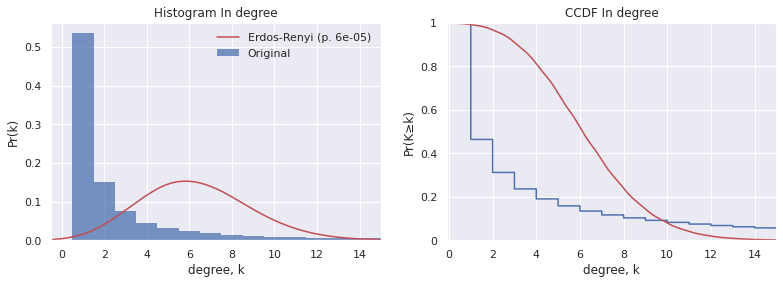

In [296]:
# Degree
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(13,4))
plt.subplots_adjust(wspace=0.2)

sns.histplot(data=vertex_df, x='degree',stat='probability',discrete=True,fill=True,label='Original',ax=ax1)
sns.kdeplot(data=vertex_er_df, x='degree', bw_adjust=3, color='r',label='Erdos-Renyi (p. 6e-05)',ax=ax1)
ax1.set_xlim(-.5, 15)
ax1.set_ylabel('Pr(k)')
ax1.set_xlabel('degree, k')
ax1.legend()
ax1.set_title('Histogram In degree')

sns.ecdfplot(data=vertex_df,x='degree',complementary=False,label='Original',ax=ax2)
sns.kdeplot(data=vertex_er_df,x='degree',color='r',cumulative=True,bw_adjust=1.5,label='Erdos-Renyi (p. 6e-05)',ax=ax2)
yticks=ax2.get_yticks()
ax2.invert_yaxis()
ax2.set_yticklabels([1,0.8,0.6,0.4,0.2,0])
ax2.set_xlim(-.1, 15)
ax2.set_ylabel('Pr(K≥k)')
ax2.set_xlabel('degree, k')
ax2.set_title('CCDF In degree')
plt.show()

In [ ]:
cl = er_g.clusters(mode='strong') # Calculates the (strong or weak) clusters (connected components) for a given graph.
lcc = cl.giant() #Returns the largest cluster
print(lcc.vcount())
print("{0:.2%}".format((lcc.vcount()/g.vcount())))
print(er_g.diameter())
print(er_g.average_path_length())
print(round(er_g.density(),5))
print(er_g.transitivity_undirected())
print(nx.transitivity(er_G))

Se ve claramente que el modelo es muy diferente a nuestra red, sobre todo en relación a los grados out de los vertices.

El modelo Erdos-Renyi situa mucha densidad entorno al grado medio y muy poca en los nodos con grados extremos.

Para los grados in de nuestros vertices, el modelo se comporta mejor, pero estima muy por debajo los nodos de grado 1.

Medidas:

- **Componente más largo**: (19709, 59.65%) vs (**59**, 0.18%)
- **Diametro (lmax)**: 35 vs **17**
- **Distancia media <l>**: 14.72 vs **4.85**
- **Densidad**: 6e-5 vs **6e-5**
- **Coeficiente de agrupamiento (global)**: 1.6e-05 vs **3e-04**

El componente más largo, el diametro y la distancia media ahora son mucho más grandes. Mientras que el coeficiente de agrupamiento es más pequeño.

Con esto llegamos a la conclusión que las características estructurales de nuestra red que no están explicadas por la densidad de las aristas.


## Scale-free model

https://aaronclauset.github.io/teaching.htm

https://stackoverflow.com/questions/49908014/how-can-i-check-if-a-network-is-scale-free

https://arxiv.org/pdf/1305.0215.pdf



Out Degree

In [268]:
result = ig.power_law_fit(vertex_df.out_degree, method='discrete', xmin=5)
print(result)

Fitted power-law distribution on discrete data

Exponent (alpha)  = 1.675369
Cutoff (xmin)     = 5.000000

Log-likelihood    = -14301.478915

H0: data was drawn from the fitted distribution

KS test statistic = 0.033981
p-value           = 0.001067

H0 rejected at significance level 0.05


In [269]:
import powerlaw # Power laws are probability distributions with the form:p(x)∝x−α
fit = powerlaw.Fit(vertex_df.out_degree, discrete=True, xmin=5)

print(fit.power_law.alpha)
print(fit.power_law.xmin)

1.6732042699354395
5.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Text(0.5, 1.0, 'CCDF Out degree (log-scale)')

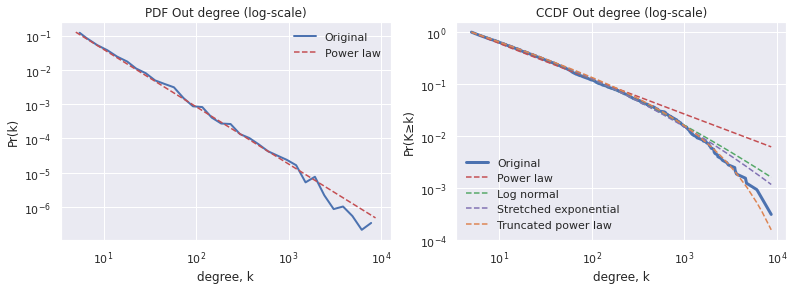

In [270]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(13,4))
plt.subplots_adjust(wspace=0.2)
fit.plot_pdf(color='b', linewidth=2, ax=ax1, label='Original')
fit.power_law.plot_pdf(color='r', linestyle='--', ax=ax1, label='Power law')
ax1.set_ylabel('Pr(k)')
ax1.set_xlabel('degree, k')
ax1.legend()
ax1.set_title('PDF Out degree (log-scale)')

fit.plot_ccdf(linewidth=3, color='b', ax=ax2, label='Original')
fit.power_law.plot_ccdf(ax=ax2, color='r', linestyle='--', label='Power law') #powerlaw
fit.lognormal.plot_ccdf(ax=ax2, color='g', linestyle='--', label= 'Log normal') #lognormal
fit.stretched_exponential.plot_ccdf(ax=ax2, color='#8172b3', 
                                    linestyle='--', label='Stretched exponential') #stretched_exponential
fit.truncated_power_law.plot_ccdf(ax=ax2, color='#dd8452', 
                                  linestyle='--', label='Truncated power law') #truncated_power_law
ax2.set_ylabel('Pr(K≥k)')
ax2.set_xlabel('degree, k')
ax2.legend()
ax2.set_title('CCDF Out degree (log-scale)')

In [271]:
fit.distribution_compare('truncated_power_law', 'stretched_exponential', normalized_ratio=True)
# truncated_power_law Has  the  power  law’s  scaling  behavior  over  some  range  but  istruncated by an exponentially bounded tail

(1.0618499001832213, 0.28830383217518707)

In [272]:
fit.distribution_compare('truncated_power_law', 'lognormal', normalized_ratio=True)

(1.3903204483050002, 0.164431591180078)

In degree

In [273]:
result = ig.power_law_fit(vertex_df.in_degree, method='discrete', xmin=3)
print(result)

Fitted power-law distribution on discrete data

Exponent (alpha)  = 2.121805
Cutoff (xmin)     = 3.000000

Log-likelihood    = -65750.086381

H0: data was drawn from the fitted distribution

KS test statistic = 0.055637
p-value           = 0.000000

H0 rejected at significance level 0.05


In [274]:
fit = powerlaw.Fit(vertex_df.in_degree, discrete=True, xmin=3)

print(fit.power_law.alpha)
print(fit.power_law.xmin)

2.0967953258127983
3.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Text(0.5, 1.0, 'CCDF In degree (log-scale)')

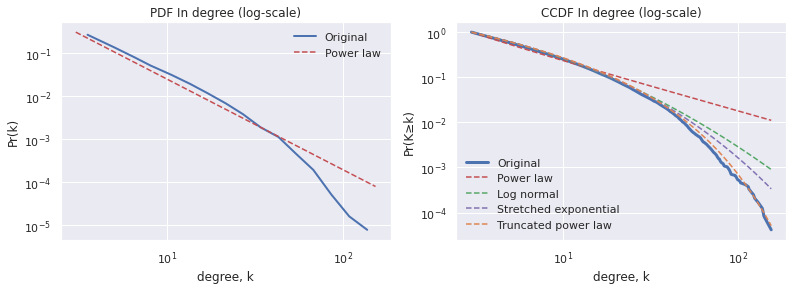

In [275]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(13,4))
plt.subplots_adjust(wspace=0.2)
fit.plot_pdf(color='b', linewidth=2, ax=ax1, label='Original')
fit.power_law.plot_pdf(color='r', linestyle='--', ax=ax1, label='Power law')
ax1.set_ylabel('Pr(k)')
ax1.set_xlabel('degree, k')
ax1.legend()
ax1.set_title('PDF In degree (log-scale)')

fit.plot_ccdf(linewidth=3, color='b', ax=ax2, label='Original')
fit.power_law.plot_ccdf(ax=ax2, color='r', linestyle='--', label='Power law') #powerlaw
fit.lognormal.plot_ccdf(ax=ax2, color='g', linestyle='--', label= 'Log normal') #lognormal
fit.stretched_exponential.plot_ccdf(ax=ax2, color='#8172b3', 
                                    linestyle='--', label='Stretched exponential') #stretched_exponential
fit.truncated_power_law.plot_ccdf(ax=ax2, color='#dd8452', 
                                  linestyle='--', label='Truncated power law') #truncated_power_law
ax2.set_ylabel('Pr(K≥k)')
ax2.set_xlabel('degree, k')
ax2.legend()
ax2.set_title('CCDF In degree (log-scale)')

In [276]:
fit.distribution_compare('truncated_power_law', 'stretched_exponential')

(37.100894661654976, 3.7063931103897985e-10)

In [277]:
fit.distribution_compare('truncated_power_law', 'lognormal')

(85.10361564342185, 1.2885934573736566e-20)

Total Degree

In [303]:
result = ig.power_law_fit(vertex_df.degree, method='discrete', xmin=1)
print(result)

Fitted power-law distribution on discrete data

Exponent (alpha)  = 1.859030
Cutoff (xmin)     = 1.000000

Log-likelihood    = -169998.984309

H0: data was drawn from the fitted distribution

KS test statistic = 0.020692
p-value           = 0.000000

H0 rejected at significance level 0.05


In [304]:
fit = powerlaw.Fit(vertex_df.degree, discrete=True, xmin=1)

print(fit.power_law.alpha)
print(fit.power_law.xmin)

1.709010272843726
1.0


/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Text(0.5, 1.0, 'CCDF Total degree (log-scale)')

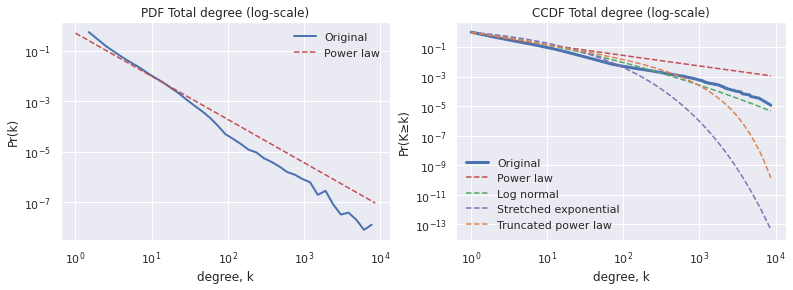

In [305]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(13,4))
plt.subplots_adjust(wspace=0.2)
fit.plot_pdf(color='b', linewidth=2, ax=ax1, label='Original')
fit.power_law.plot_pdf(color='r', linestyle='--', ax=ax1, label='Power law')
ax1.set_ylabel('Pr(k)')
ax1.set_xlabel('degree, k')
ax1.legend()
ax1.set_title('PDF Total degree (log-scale)')

fit.plot_ccdf(linewidth=3, color='b', ax=ax2, label='Original')
fit.power_law.plot_ccdf(ax=ax2, color='r', linestyle='--', label='Power law') #powerlaw
fit.lognormal.plot_ccdf(ax=ax2, color='g', linestyle='--', label= 'Log normal') #lognormal
fit.stretched_exponential.plot_ccdf(ax=ax2, color='#8172b3', 
                                   linestyle='--', label='Stretched exponential') #stretched_exponential
fit.truncated_power_law.plot_ccdf(ax=ax2, color='#dd8452', 
                                  linestyle='--', label='Truncated power law') #truncated_power_law
ax2.set_ylabel('Pr(K≥k)')
ax2.set_xlabel('degree, k')
ax2.legend()
ax2.set_title('CCDF Total degree (log-scale)')

In [306]:
fit.distribution_compare('power_law', 'lognormal')

(-1912.4353338577102, 0.0)

In [307]:
print(fit.lognormal.mu)

-3.379140842250874


In [308]:
print(fit.lognormal.sigma)

2.527982206478624


Finally, take into account that powerlaw distributions in networks are being under discussion now, strongly scale-free networks seem to be empirically rare

https://www.nature.com/articles/s41467-019-08746-5


Followers

In [323]:
result = ig.power_law_fit(vertex_df.followers_count, method='discrete', xmin=2033)
print(result)

Fitted power-law distribution on discrete data

Exponent (alpha)  = 2.041497
Cutoff (xmin)     = 2033.000000

Log-likelihood    = -110575.941646

H0: data was drawn from the fitted distribution

KS test statistic = 0.010892
p-value           = 0.127676

H0 could not be rejected at significance level 0.05


In [325]:
fit = powerlaw.Fit(vertex_df.followers_count, discrete=True, xmin=2033)

print(fit.power_law.alpha)
print(fit.power_law.xmin)

2.041496881921984
2033.0


Values less than or equal to 0 in data. Throwing out 0 or negative values
/usr/local/lib/python3.7/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Text(0.5, 1.0, 'CCDF Followers (log-scale)')

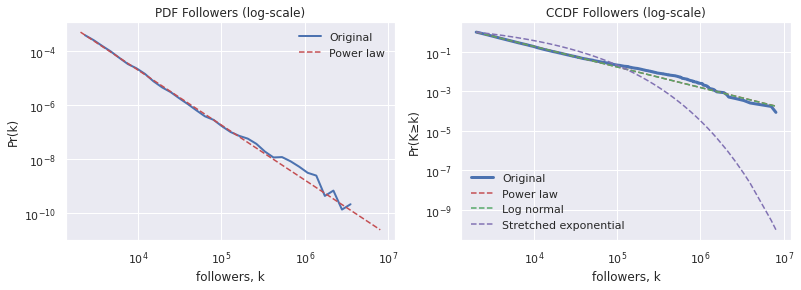

In [328]:
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(13,4))
plt.subplots_adjust(wspace=0.2)
fit.plot_pdf(color='b', linewidth=2, ax=ax1, label='Original')
fit.power_law.plot_pdf(color='r', linestyle='--', ax=ax1, label='Power law')
ax1.set_ylabel('Pr(k)')
ax1.set_xlabel('followers, k')
ax1.legend()
ax1.set_title('PDF Followers (log-scale)')

fit.plot_ccdf(linewidth=3, color='b', ax=ax2, label='Original')
fit.power_law.plot_ccdf(ax=ax2, color='r', linestyle='--', label='Power law') #powerlaw
fit.lognormal.plot_ccdf(ax=ax2, color='g', linestyle='--', label= 'Log normal') #lognormal
fit.stretched_exponential.plot_ccdf(ax=ax2, color='#8172b3', 
                                   linestyle='--', label='Stretched exponential') #stretched_exponential
ax2.set_ylabel('Pr(K≥k)')
ax2.set_xlabel('followers, k')
ax2.legend()
ax2.set_title('CCDF Followers (log-scale)')

In [327]:
fit.distribution_compare('power_law', 'lognormal')

(0.24353252516500312, 0.003801526191664791)

# Clasificación de nodos

## Por grado

**ratio_degree** = degree_out / degree_in

- Listener (oyente) --- 0 <= ratio <= 0.5
- Transmitter/Dialoguer (dialogador) --- 0.5 < ratio < 2 
- Emitter (emisor) --- ratio >= 2 

In [ ]:
vertex_df['ratio_degree'] = (vertex_df['out_degree']) / (vertex_df['in_degree'])

In [ ]:
def get_degree_class(x):
  if 0<=x<=0.5:
    return 'Listener'
  elif 0.5<x<2:
    return 'Transmitter/Dialoguer'
  elif x>=2:
    return 'Emitter'
  else:
    return None

vertex_df['degree_class'] = vertex_df['ratio_degree'].apply(lambda x: get_degree_class(x))

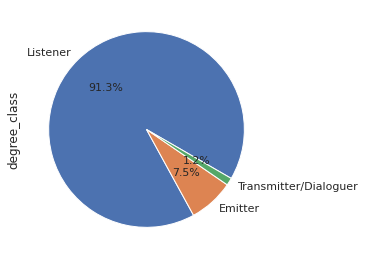

In [ ]:
vertex_df['degree_class'].value_counts(normalize=True).plot(kind='pie', fontsize=11,
                                                           autopct='%1.1f%%', startangle=-30, figsize=(4.5,4.5))

## Por tipo de usuario

https://azsocialmediawiz.com/5-types-twitter-users/

**ratio_user** = followers_count / friends_count

The Newsmaker --- ratio_user >= 2

Information Gatherer --- 0 <= ratio_user <= 0.5

Relationship Builder --- 0.5 < ratio_user < 2

Newbie --- 0.5 < ratio_user < 2 y followers_count < 100

Spammer/Fake --- 

- Cuenta con un ratio_user < 0.7
- Menos de 500 followers
- Ratio de contenido(tweets + favs) /followers alto
- Ratio de contenido(tweets + favs) /dias alto



In [ ]:
vertex_df['ratio_user'] = (vertex_df['followers_count'] / (vertex_df['friends_count']+1))
vertex_df['ratio_tweets_followers'] = (vertex_df['statuses_count']+vertex_df['favourites_count'])/ (vertex_df['followers_count']+1)
vertex_df['ratio_tweets_antiguedad'] =(vertex_df['statuses_count']+vertex_df['favourites_count']) / (vertex_df['days_old']+1)

vertex_df['ratio_spam'] = 0.3*vertex_df['ratio_tweets_followers'] + 0.7*vertex_df['ratio_tweets_antiguedad']

In [ ]:
vertex_df[['followers_count','friends_count','ratio_user']].describe().round(2)

,followers_count,friends_count,ratio_user
count,33040.00,33040.00,33040.00
mean,4132.22,1349.19,12.50
std,68206.57,2694.37,591.01
min,0.00,0.00,0.00
25%,121.00,243.00,0.37
50%,381.00,610.00,0.66
75%,1285.00,1501.00,1.03
max,8037826.00,96502.00,63508.00


In [ ]:
ratio_spam_cut = vertex_df[(vertex_df['ratio_user']<0.7)&(vertex_df['followers_count']<500)]['ratio_spam'].quantile(0.85)

def get_user_class(x):
  if x['ratio_user']<0.7 and x['followers_count']<500 and x['ratio_spam']>=ratio_spam_cut:
    return 'Spammer/Fake'
  elif x['ratio_user']<=0.5:
    return 'Information Gatherer'
  elif 0.5<x['ratio_user']<2 and x['followers_count']<100:
    return 'Newbie'
  elif 0.5<x['ratio_user']<2:
    return 'Relationship Builder'
  elif x['ratio_user']>=2:
    return 'The Newsmaker'
  else:
    return 'Spammer/Fake'

In [ ]:
vertex_df['user_class'] = vertex_df.apply(lambda x: get_user_class(x), axis=1)

In [ ]:
vertex_df.user_class.value_counts()

Relationship Builder    15744
Information Gatherer    10597
The Newsmaker            3224
Spammer/Fake             2011
Newbie                   1464
Name: user_class, dtype: int64

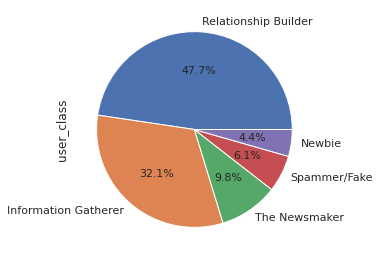

In [ ]:
color_dict = {'Relationship Builder':'b', 
              'Information Gatherer':'#dd8452',
              'The Newsmaker':'g',
              'Spammer/Fake':'r',
              'Newbie':'#8172b3'}
# https://moonbooks.org/Articles/How-to-extract-html-color-codes-hex-codes-from-a-seaborn-palette-/

vertex_df.user_class.value_counts().plot(kind='pie', fontsize=11,
                                         autopct='%1.1f%%', startangle=0, figsize=(4.5,4.5),
                                         colors=[color_dict.get(x) for x in vertex_df.user_class.value_counts().keys()])

## Correlación

In [ ]:
vertex_df[['followers_count','out_degree','ratio_degree','ratio_user']].corr()

,followers_count,out_degree,ratio_degree,ratio_user
followers_count,1.000000,0.195565,0.258285,0.278746
out_degree,0.195565,1.000000,0.904716,0.023393
ratio_degree,0.258285,0.904716,1.000000,0.084275
ratio_user,0.278746,0.023393,0.084275,1.000000


In [ ]:
vertex_df.ratio_degree.quantile(0.9)

0.0

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


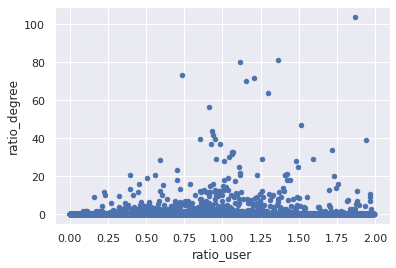

In [ ]:
scatter_df = vertex_df[vertex_df['ratio_degree']<125]
scatter_df = scatter_df[scatter_df['ratio_user']<2]
scatter_df.plot(x='ratio_user',y='ratio_degree',kind='scatter')

# El 90% tiene ratio degree de 0, no existe correlación directa

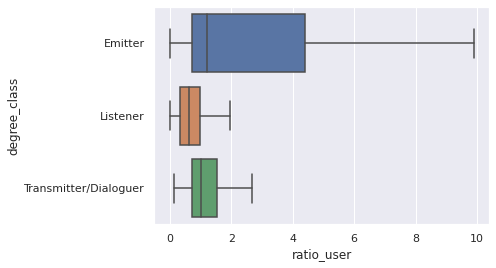

In [ ]:
sns.boxplot(x='ratio_user', y='degree_class', data=vertex_df, orient='h', showfliers=False)

(0.0, 1.0, 0.0, 1.0)

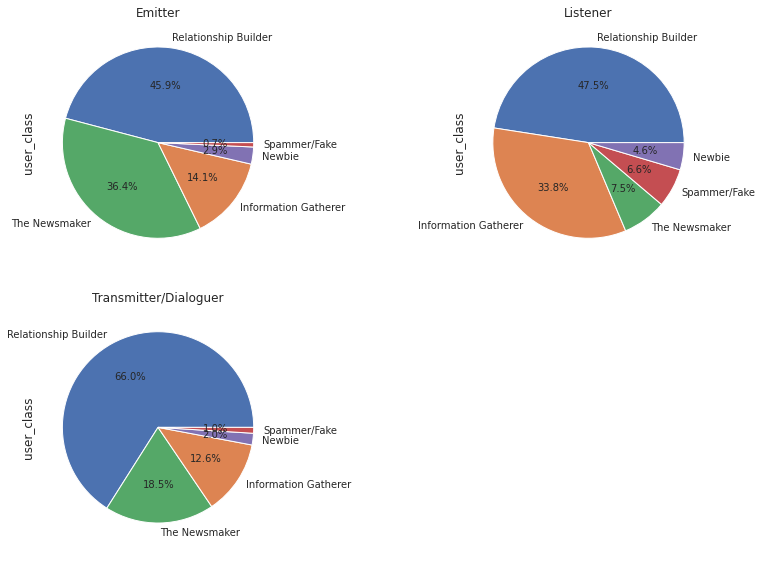

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))
plt.subplots_adjust(wspace=0.8,hspace=0.1)

vertex_df[vertex_df['degree_class']=='Emitter'].user_class.value_counts().plot(kind='pie', fontsize=10,
                                                autopct='%1.1f%%', startangle=0, title='Emitter',
                                                ax=axes[0,0], 
                                                colors=[color_dict.get(x) for x in vertex_df[vertex_df['degree_class']=='Emitter'].user_class.value_counts().keys()])
vertex_df[vertex_df['degree_class']=='Listener'].user_class.value_counts().plot(kind='pie', fontsize=10,
                                                autopct='%1.1f%%', startangle=0, title='Listener',
                                                ax=axes[0,1],
                                                colors=[color_dict.get(x) for x in vertex_df[vertex_df['degree_class']=='Listener'].user_class.value_counts().keys()])
vertex_df[vertex_df['degree_class']=='Transmitter/Dialoguer'].user_class.value_counts().plot(kind='pie', fontsize=10,
                                                autopct='%1.1f%%', startangle=0, title='Transmitter/Dialoguer',
                                                ax=axes[1,0],
                                                colors=[color_dict.get(x) for x in vertex_df[vertex_df['degree_class']=='Transmitter/Dialoguer'].user_class.value_counts().keys()])
axes[1,1].axis('off')

# Rankings
https://es.wikipedia.org/wiki/Centralidad

## Seguidores

In [ ]:
vertex_df.sort_values(by='followers_count',ascending=False)[['_nx_name','followers_count','degree_class','user_class']].head(10)

,_nx_name,followers_count,degree_class,user_class
vertex ID,,,,
199,el_pais,8037826.0,Emitter,The Newsmaker
337,elmundoes,3935007.0,Emitter,The Newsmaker
26489,Reforma,3307874.0,Emitter,The Newsmaker
798,PabloIglesias,2649270.0,Emitter,The Newsmaker
2199,abc_es,2115599.0,Emitter,The Newsmaker
2111,A3Noticias,1984852.0,Emitter,The Newsmaker
10862,EFEnoticias,1909405.0,Emitter,The Newsmaker
8170,sanchezcastejon,1567759.0,Emitter,The Newsmaker
4,PODEMOS,1526489.0,Emitter,The Newsmaker


## Grado de salida

Los que llegan a máás gente

In [ ]:
vertex_df.sort_values(by='out_degree',ascending=False)[['_nx_name','followers_count','out_degree',
                                                        'in_degree','degree_class','user_class']].head(10)

,_nx_name,followers_count,out_degree,in_degree,degree_class,user_class
vertex ID,,,,,,
12,Tonicanto1,390662.0,3619,0,Emitter,The Newsmaker
8,RubenSanchezTW,276951.0,2402,0,Emitter,The Newsmaker
4,PODEMOS,1526489.0,2322,2,Emitter,The Newsmaker
18,ElHuffPost,511029.0,1895,1,Emitter,The Newsmaker
23,PSOE,822624.0,1579,4,Emitter,The Newsmaker
63,vox_es,438802.0,1426,2,Emitter,The Newsmaker
3,JulianMaciasT,59564.0,1338,2,Emitter,The Newsmaker
30,janogarcia_,190965.0,1110,0,Emitter,The Newsmaker
16,luisgonzaloseg,60811.0,940,0,Emitter,The Newsmaker


## Grado de entrada

Los que reciben más información

In [ ]:
vertex_df.sort_values(by='in_degree',ascending=False)[['_nx_name','followers_count','out_degree',
                                                        'in_degree','degree_class','user_class']].head(10)

,_nx_name,followers_count,out_degree,in_degree,degree_class,user_class
vertex ID,,,,,,
25662,jpmg71,731.0,0,46,Listener,Relationship Builder
26634,locuspolitikus,12162.0,0,45,Listener,Relationship Builder
19664,aneshali,4892.0,0,41,Listener,Relationship Builder
27702,troyana25,2833.0,1,41,Listener,The Newsmaker
1254,psoe_m,33007.0,87,40,Emitter,The Newsmaker
20516,bimbalalombarda,1079.0,1,39,Listener,Information Gatherer
29858,pilichus,1693.0,0,38,Listener,Relationship Builder
4099,Carmen56257613,463.0,0,37,Listener,Information Gatherer
2057,cleosagas1,8451.0,21,36,Transmitter/Dialoguer,Relationship Builder


## Capacidad de difusión RT
 
¿A cuánta gente han podido llegar con su RT? (in_degree * followers)

Sustituye a la definición de cercania, ya que esta no se puede calcular, la distancia entre la mayoría de nodos es infinita (los que están más "cerca" de la gente).

In [ ]:
vertex_df['diffusion_capacity'] = vertex_df['in_degree'] * vertex_df['followers_count']
vertex_df.sort_values(by='diffusion_capacity',ascending=False)[['_nx_name','followers_count', 'diffusion_capacity',
                                                       'out_degree','in_degree','degree_class','user_class']].head(10)

,_nx_name,followers_count,diffusion_capacity,out_degree,in_degree,degree_class,user_class
vertex ID,,,,,,,
199,el_pais,8037826.0,8037826.0,317,1,Emitter,The Newsmaker
23,PSOE,822624.0,3290496.0,1579,4,Emitter,The Newsmaker
4,PODEMOS,1526489.0,3052978.0,2322,2,Emitter,The Newsmaker
261,CiudadanosCs,521014.0,2084056.0,509,4,Emitter,The Newsmaker
33,Santi_ABASCAL,576906.0,1730718.0,655,3,Emitter,The Newsmaker
2306,rtvenoticias,1462027.0,1462027.0,14,1,Emitter,The Newsmaker
386,europapress,1400175.0,1400175.0,115,1,Emitter,The Newsmaker
1254,psoe_m,33007.0,1320280.0,87,40,Emitter,The Newsmaker
2921,rtve,1204260.0,1204260.0,22,1,Emitter,The Newsmaker


## Flow betweenness
http://www.analytictech.com/ucinet/help/1li6nw4.htm

https://www.centiserver.org/centrality/Flow_Betweenness_Centrality/

https://rdrr.io/cran/sna/man/flowbet.html

No existen librerias que lo calculen en Python para grafos dirigidos y en R se queda sin memoria con más de 20000 nodos

In [ ]:
#%%R
#library(sna)
#g<-rgraph(33040, tprob=0.00006, mode="digraph")  
#flowbet(g) 

#sna::flowbet(get.adjacency(g,sparse=F))

UsageError: Cell magic `%%R` not found.


In [ ]:
#vertex_df['flow_betweenness'] = nx.edge_current_flow_betweenness_centrality(G)

In [ ]:
#vertex_df.sort_values(by='flow_betweenness',ascending=False)[['_nx_name','followers_count','flow_betweenness',
#                                                              'out_degree','in_degree','degree_class',
#                                                              'user_class']].head(10)

## HITS

https://es.wikipedia.org/wiki/PageRank

https://es.wikipedia.org/wiki/Algoritmo_HITS


In [ ]:
h,a = nx.hits(G)
vertex_df['hub_score'] = h.values()
vertex_df['authority_score'] = a.values()

### Hubs 
(A node is high-quality if it links to many high-quality nodes)

In [ ]:
vertex_df.sort_values(by='hub_score',ascending=False)[['_nx_name','followers_count','hub_score',
                                                       'out_degree','in_degree','degree_class',
                                                       'user_class']].head(10)

,_nx_name,followers_count,hub_score,out_degree,in_degree,degree_class,user_class
vertex ID,,,,,,,
23,PSOE,822624.0,0.686364,1579,4,Emitter,The Newsmaker
117,equipoGabilondo,58018.0,0.017599,355,1,Emitter,The Newsmaker
677,pedro_casares,8139.0,0.013692,128,3,Emitter,The Newsmaker
528,gpscongreso,50885.0,0.012398,91,1,Emitter,The Newsmaker
18,ElHuffPost,511029.0,0.012228,1895,1,Emitter,The Newsmaker
356,patxilopez,199061.0,0.009591,278,1,Emitter,The Newsmaker
21,Marsais_,8406.0,0.009455,80,21,Emitter,The Newsmaker
1006,JSMadrid,13134.0,0.008465,104,1,Emitter,Relationship Builder
0,AmoedoCom,20318.0,0.007544,448,2,Emitter,Relationship Builder


### Authorities

(A node is high-quality if many high-quality nodes link to it)

Para nuestro caso no le veo el sentido a calcularlo. Si una persona da RTs a gente importante aparece primero.

In [ ]:
vertex_df.sort_values(by='authority_score',ascending=False)[['_nx_name','followers_count','authority_score',
                                                             'out_degree','in_degree','degree_class',
                                                             'user_class']].head(10)

,_nx_name,followers_count,authority_score,out_degree,in_degree,degree_class,user_class
vertex ID,,,,,,,
30174,psoebetxi,1644.0,0.007694,0,9,Listener,Relationship Builder
24044,harrypedro7,1367.0,0.007043,0,14,Listener,Relationship Builder
4394,CeutaPlataforma,697.0,0.007039,0,8,Listener,Information Gatherer
31604,soniapillado70,4618.0,0.007032,0,14,Listener,The Newsmaker
4395,WillyLozano,4425.0,0.007029,32,8,Emitter,Relationship Builder
5329,DRZRZ,27609.0,0.007027,2,10,Listener,Relationship Builder
25148,jlseto,1345.0,0.006902,0,33,Listener,The Newsmaker
5332,smarttcom,3627.0,0.006883,41,35,Transmitter/Dialoguer,Relationship Builder
15432,RAFAELLEALSALAZ,5404.0,0.006877,0,11,Listener,Relationship Builder
